# Protein Function Predictions Using GNNs
## Data pre-processing, data processing, and model training (Deep Neural Network vs Deep Neural Network + Graph Sage + Deep Neural Network + Graph Attention)

In [ ]:
!pip install torch==2.4.0
!pip install torch-geometric==2.4.0
!pip install biopython
!pip install obonet
!pip install networkx
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install fair-esm
import torch
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.8 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 138.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 89.3 MB/s eta 0:00:00


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # avoid fragmentation
import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import Bio
from Bio import SeqIO
import obonet
import gc
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import esm


In [ ]:
obo_path = 'go-basic.obo'
fasta_path = 'train_sequences.fasta'
term_path = 'train_terms.tsv'
taxonomy_path = 'train_taxonomy.tsv'
fasta_test_path = "testsuperset.fasta"
taxonomy_test_path = "testsuperset-taxon-list.tsv"


In [ ]:
LARGEST_FASTA_SEQ_LEN = 8922
ESM_EMBEDDING_DIM = 320
PCA_TARGET_DIM = 128

In [ ]:
taxonomy_test_df = pd.read_csv(taxonomy_test_path, sep='\t')
taxonomy_test_df.head()

,ID,Species
0,9606,Homo sapiens
1,10116,Rattus norvegicus
2,39947,Oryza sativa subsp. japonica
3,7955,Danio rerio
4,7227,Drosophila melanogaster


In [ ]:
fasta_data_train = list(SeqIO.parse(fasta_path, "fasta"))

In [ ]:
len(fasta_data_train), fasta_data_train[:5]

(82404,
 [SeqRecord(seq=Seq('MRWQEMGYIFYPRKLR'), id='sp|A0A0C5B5G6|MOTSC_HUMAN', name='sp|A0A0C5B5G6|MOTSC_HUMAN', description='sp|A0A0C5B5G6|MOTSC_HUMAN Mitochondrial-derived peptide MOTS-c OS=Homo sapiens OX=9606 GN=MT-RNR1 PE=1 SV=1', dbxrefs=[]),
  SeqRecord(seq=Seq('MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVLQNMLDLPT...TVE'), id='sp|A0JNW5|BLT3B_HUMAN', name='sp|A0JNW5|BLT3B_HUMAN', description='sp|A0JNW5|BLT3B_HUMAN Bridge-like lipid transfer protein family member 3B OS=Homo sapiens OX=9606 GN=BLTP3B PE=1 SV=2', dbxrefs=[]),
  SeqRecord(seq=Seq('MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTSGDHDDSFM...TSI'), id='sp|A0JP26|POTB3_HUMAN', name='sp|A0JP26|POTB3_HUMAN', description='sp|A0JP26|POTB3_HUMAN POTE ankyrin domain family member B3 OS=Homo sapiens OX=9606 GN=POTEB3 PE=1 SV=2', dbxrefs=[]),
  SeqRecord(seq=Seq('MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDLVNATDREL...ILY'), id='sp|A0PK11|CLRN2_HUMAN', name='sp|A0PK11|CLRN2_HUMAN', description='sp|A0PK11|CLRN2_HUMAN Clarin-2

In [ ]:
fasta_data = list(SeqIO.parse(fasta_test_path, "fasta"))

In [ ]:
len(fasta_data), fasta_data[:5]

(224309,
 [SeqRecord(seq=Seq('MRWQEMGYIFYPRKLR'), id='A0A0C5B5G6', name='A0A0C5B5G6', description='A0A0C5B5G6 9606', dbxrefs=[]),
  SeqRecord(seq=Seq('MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKSRSSSLTLP...REV'), id='A0A1B0GTW7', name='A0A1B0GTW7', description='A0A1B0GTW7 9606', dbxrefs=[]),
  SeqRecord(seq=Seq('MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVLQNMLDLPT...TVE'), id='A0JNW5', name='A0JNW5', description='A0JNW5 9606', dbxrefs=[]),
  SeqRecord(seq=Seq('MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTSGDHDDSFM...TSI'), id='A0JP26', name='A0JP26', description='A0JP26 9606', dbxrefs=[]),
  SeqRecord(seq=Seq('MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDLVNATDREL...ILY'), id='A0PK11', name='A0PK11', description='A0PK11 9606', dbxrefs=[])])

In [ ]:
term_df = pd.read_csv(term_path, sep='\t')
term_df.head(), len(term_df["term"].unique()), term_df.count()

(  EntryID        term aspect
 0  Q5W0B1  GO:0000785      C
 1  Q5W0B1  GO:0004842      F
 2  Q5W0B1  GO:0051865      P
 3  Q5W0B1  GO:0006275      P
 4  Q5W0B1  GO:0006513      P,
 26125,
 EntryID    537027
 term       537027
 aspect     537027
 dtype: int64)

In [ ]:
taxonomy_df = pd.read_csv(taxonomy_path, sep='\t', names=['EntryID', 'taxonomyID'])
taxonomy_df.head()

,EntryID,taxonomyID
0,A0A0C5B5G6,9606
1,A0JNW5,9606
2,A0JP26,9606
3,A0PK11,9606
4,A1A4S6,9606


In [ ]:
# def get_processed_fasta_df(fasta_data, term_df):
#     fasta_dict_list = []
#     term_set = set(term_df.tolist())
#     for fasta_seq in fasta_data:
#         entry = fasta_seq.id.split('|')[1] if '|' in fasta_seq.id else fasta_seq.id
#         if entry in term_set:
#             fasta_dict_list.append({
#                 "EntryID": entry,
#                 "fasta_sequence": str(fasta_seq.seq)
#             })

#     return pd.DataFrame(fasta_dict_list)


def sample_tsv(tsv_df, sample_frac=0.05, random_state=42):
    """
    Read a TSV file and sample based on unique EntryID.
    Pulls in all associated rows for sampled EntryIDs.
    """
    df = tsv_df
    unique_ids = df['EntryID'].unique()
    sample_size = max(1, int(len(unique_ids) * sample_frac))
    sampled_ids = random.sample(list(unique_ids), sample_size)
    sampled_df = df[df['EntryID'].isin(sampled_ids)]
    print(f"Sampled {len(sampled_df)} rows from {len(unique_ids)} unique EntryIDs")
    return sampled_df


def get_processed_fasta_df(fasta_data):
    fasta_dict_list = []
    for fasta_seq in fasta_data:
        entry = fasta_seq.id.split('|')[1] if '|' in fasta_seq.id else fasta_seq.id
        fasta_dict_list.append({
                "EntryID": entry,
                "fasta_sequence": str(fasta_seq.seq)
            })

    return pd.DataFrame(fasta_dict_list)





# Get Merged DF FULL (includes batching to fit embeddings into GPU and offloads to CPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
model = model.to(device)
model = model.half()
model.eval()
batch_converter = alphabet.get_batch_converter()

def generate_protein_embeddings_esm_batch(seq_df, seq_col='Sequence', entryid_col='EntryID',
                                              target_dim=16, batch_size=1, use_fp16=True):
    """
    Memory-optimized ESM embedding generation for proteins.
    Processes small batches and moves embeddings to CPU immediately.
    """
    sequences = seq_df[seq_col].tolist()
    entry_ids = seq_df[entryid_col].tolist()
    print(f"sequences: {len(sequences)} entry_ids {len(entry_ids)}")

    all_embeddings = []
    # print(len(sequences))
    dtype = torch.float16 if use_fp16 else torch.float32
    for i in range(0, len(sequences), batch_size):
        try:
            batch_seqs = sequences[i:i+batch_size]
            batch_labels = entry_ids[i:i+batch_size]
            if len(batch_seqs[0]) > LARGEST_FASTA_SEQ_LEN:
                print(f"length of batch seqs is: {len(batch_seqs[0])}")
                # Split the sequence to be max length LARGEST_FASTA_SEQ_LEN (will always be len 1 batch), this helps avoid the loss of information
                curr_seq = batch_seqs[0]
                embeddings_list = []
                for i in range(0, len( batch_seqs[0]), LARGEST_FASTA_SEQ_LEN):
                  curr_seq = batch_seqs[0][i:i+LARGEST_FASTA_SEQ_LEN]
                  curr_seq_embedding = get_sequence_embedding_esm(batch_labels, [curr_seq], dtype)
                  embeddings_list.append(curr_seq_embedding)
                # Average the embeddings_list since the long sequences were broken down into smaller chunks
                seq_embeddings = np.mean(embeddings_list, axis=0)

            else:
              seq_embeddings = get_sequence_embedding_esm(batch_labels, batch_seqs, dtype)

            all_embeddings.append(seq_embeddings)
            del seq_embeddings
        except Exception as e:
            print(e)
            print(len(batch_seqs[0]))
            print(batch_seqs)


    raw_embeddings = np.vstack(all_embeddings)
    # Mitigate memory constraints
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    torch.cuda.reset_peak_memory_stats()

    col_names = [f"prot_emb_{i}" for i in range(320)]
    emb_df = pd.DataFrame(raw_embeddings, index=entry_ids, columns=col_names)
    emb_df.index.name = entryid_col

    return emb_df


def get_sequence_embedding_esm(batch_labels, batch_seqs, dtype):
    batch_data = [(label, seq) for label, seq in zip(batch_labels, batch_seqs)]
    _, _, batch_tokens = batch_converter(batch_data)
    batch_tokens = batch_tokens.to(device)
    with torch.no_grad():
      with torch.autocast(device_type="cuda", dtype=dtype):
          results = model(batch_tokens, repr_layers=[model.num_layers], return_contacts=False)
          token_embeddings = results["representations"][model.num_layers]  # (B, L, D)
          # Mean pool over sequence length
          attention_mask = batch_tokens != alphabet.padding_idx
          masked_embeddings = token_embeddings * attention_mask.unsqueeze(-1)
          seq_lengths = attention_mask.sum(dim=1).unsqueeze(-1)
          seq_embeddings = (masked_embeddings.sum(dim=1) / seq_lengths).cpu().float().numpy()
          del batch_tokens, token_embeddings, masked_embeddings, results, attention_mask
          return seq_embeddings


def apply_pca_to_esm_embeddings(esm_embeddings_df:pd.DataFrame, target_dim=16):
    '''
    Helper method
    '''
    emb_cols = [c for c in esm_embeddings_df.columns if c.startswith("prot_emb")]

    tensor_list = [
        torch.tensor(row[emb_cols].values.astype("float16"), dtype=torch.float16)
        for _, row in esm_embeddings_df.iterrows()
    ]

    pca = PCA(n_components=PCA_TARGET_DIM)
    tensor_list_transformed = pca.fit_transform(tensor_list)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    save_path = 'pca_variance_plot.png'  # Colab's root directory
    plt.savefig(save_path, dpi=300)

    # Intialize dictionary where we use EntryID for joining with all the other data
    embeddings_dict = { "EntryID": [] }
    # Initialize empty PCA embeddings for the pd.DataFrame
    for i in range(PCA_TARGET_DIM):
        embeddings_dict[f"emb_{i}"] =  []

    # Append EntryID's and embeddings to the dictionary for the dataframe
    for i, r in enumerate(tensor_list_transformed):
        curr_entry_id = esm_embeddings_df["EntryID"][i]
        embeddings_dict["EntryID"].append(curr_entry_id)
        for j in range(PCA_TARGET_DIM):
            embeddings_dict[f"emb_{j}"].append(r[j])

    pca_embeddings_df = pd.DataFrame(embeddings_dict)
    return pca_embeddings_df




Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


537027

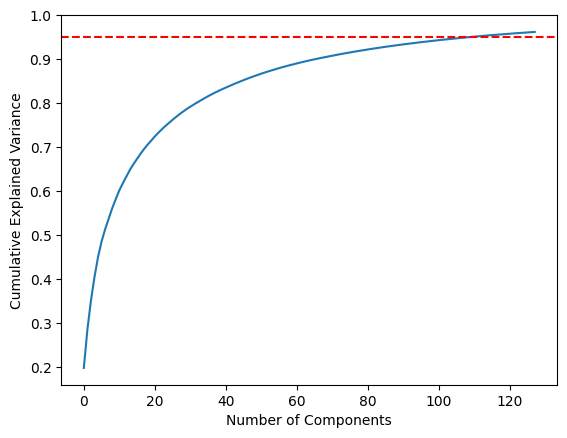

In [ ]:
file_name = "fasta_embeddings_final (2).csv"
embeddings_processed = True # If set to false will start generating embeddings with a batched approach

def get_merged_df_full(file_name, fasta_file, batch_size=250, embeddings_processed=False):
    """
    file_name: name of the .csv file we want to read/generate embeddings using a batch strategy
    fasta_file: path of the fasta file.
    batch_size: number of sequences to process at a time.
    embeddings_processed: if set to True will attempt to read the file directly, if set to False it will start
    the batch process to generate embeddings for the protein sequences.

    Merge term.tsv, fasta data, taxonomy data as well as nodes in the obo graph with the goal of creating a centralized dataset.
    A batched approach is used in order to avoid losing progress and 250 embeddings are written to the file_name variable
    in append only mode.

    Once embeddings are processed, PCA is performed with 128 dimensions (320 are the embeddings for ESM2 8M) while preserving
     95% of the variance, reducing the dimensionality of the embeddings.
    """
    term_df = pd.read_csv(term_path, sep='\t')
    term_df = term_df
    taxonomy_df = pd.read_csv(taxonomy_path, sep='\t', names=['EntryID', 'taxonomyID'])
    fasta_data = list(SeqIO.parse(fasta_file, "fasta"))

    entry_ids = list(term_df['EntryID'])
    all_batches = []
    fasta_data_processed = get_processed_fasta_df(fasta_data)
    if not embeddings_processed:
      for i in range(0, len(fasta_data_processed), batch_size):
          total_processed = i
          print(f"Total processed: {total_processed}, {i//batch_size} batch")
          fasta_df_batch = fasta_data_processed[i:i+batch_size]
          fasta_emb_df_batch = generate_protein_embeddings_esm_batch(
              fasta_df_batch,
              "fasta_sequence"
          )

          if os.path.exists(file_name):

              fasta_emb_df_batch.to_csv(file_name, mode='a', header=False)
          else:
              fasta_emb_df_batch.to_csv(file_name, mode='w', header=True)

    full_df = pd.read_csv(file_name)
    fasta_emb_df = apply_pca_to_esm_embeddings(full_df)

    merged_df = pd.merge(term_df, fasta_emb_df, on="EntryID", how='left')
    merged_df = pd.merge(merged_df, taxonomy_df, on="EntryID", how="left")
    graph = obonet.read_obo(obo_path)
    edges_list = []
    for node_id, data in graph.nodes(data=True):
        for parent_id in data.get("is_a", []):
            edges_list.append({
                    "term": node_id,
                    "parent": parent_id,
                    "relation": data.get('relation', 'is_a'),
                    "name": data["name"],
                    "namespace": data["namespace"],
                    "def": data["def"],
                    "synonym": data.get("synonym", [])

                })
    edges_df = pd.DataFrame(edges_list)
    return merged_df, edges_df, fasta_emb_df

protein_function_df, graph_df, fasta_emb_df = get_merged_df_full(file_name, fasta_test_path, embeddings_processed=embeddings_processed)
len(protein_function_df)

### Load test embeddings

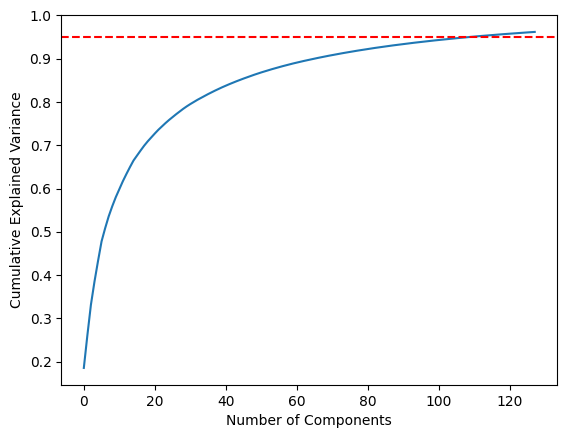

In [ ]:
file_name = "fasta_embeddings_final_test (4).csv"
protein_function_df_test, graph_df_test, fasta_emb_df = get_merged_df_full(file_name, fasta_test_path, embeddings_processed=embeddings_processed)

In [ ]:
fasta_emb_df.head(), fasta_emb_df.count()

In [ ]:
print(protein_function_df_test)

In [ ]:
test_df = pd.read_csv("fasta_embeddings_final_test.csv", sep=',')


## Test embeddings were too large, workarounds were to setup drive and a parquet version (downloading from colab was giving errors)

In [ ]:
test_df.to_parquet("fasta_embeddings_final_test.parquet")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
test_df.to_csv("/content/drive/MyDrive/fasta_embeddings_final_test.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
chunk_size = 80000
num_chunks = int(np.ceil(len(test_df) / chunk_size))

chunks = np.array_split(test_df, num_chunks)

for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: {len(chunk)} rows")
    print(f"Range: {chunk.index[0]} to {chunk.index[-1]}")

for i, chunk in enumerate(chunks):
    chunk.to_csv(f"fasta_embeddings_chunk_{i+1}.csv", index=False)
    print(f"Saved chunk {i+1} to file")

Chunk 1: 74770 rows
Range: 0 to 74769
Chunk 2: 74770 rows
Range: 74770 to 149539
Chunk 3: 74769 rows
Range: 149540 to 224308
Saved chunk 1 to file
Saved chunk 2 to file
Saved chunk 3 to file


In [ ]:
test_df.head()

,EntryID,prot_emb_0,prot_emb_1,prot_emb_2,prot_emb_3,prot_emb_4,prot_emb_5,prot_emb_6,prot_emb_7,prot_emb_8,...,prot_emb_310,prot_emb_311,prot_emb_312,prot_emb_313,prot_emb_314,prot_emb_315,prot_emb_316,prot_emb_317,prot_emb_318,prot_emb_319
0,A0A0C5B5G6,0.016567,-0.289706,0.220759,0.400631,0.027216,-0.284450,-0.224212,-0.003594,-0.097595,...,-0.025145,-0.091851,0.048823,0.085143,0.102648,0.190950,0.062733,0.037665,0.223454,-0.019907
1,A0A1B0GTW7,-0.093446,-0.254585,0.012678,0.142927,0.165390,-0.181550,0.187519,0.116364,-0.011738,...,0.186909,-0.005394,0.032888,0.168398,-0.074362,0.021446,0.094643,0.145726,0.066545,0.040935
2,A0JNW5,-0.038262,-0.072216,-0.002150,-0.106830,0.087873,-0.138739,-0.048052,0.035623,-0.053620,...,0.230535,-0.084343,0.186516,0.259755,0.030741,0.133635,-0.077207,0.210038,-0.053153,0.094084
3,A0JP26,-0.191921,-0.266046,0.000821,0.144099,-0.087803,-0.122816,0.079723,-0.025195,-0.046136,...,0.090380,0.031094,0.050814,0.252443,-0.031871,0.219190,-0.167555,0.267516,-0.168546,-0.007526
4,A0PK11,0.008440,-0.014297,0.175595,0.166315,-0.125216,-0.022252,-0.099803,0.003853,-0.160202,...,-0.002220,0.065125,0.085714,-0.038545,0.052604,-0.095455,-0.051158,-0.049710,0.068514,0.160060


In [ ]:
plt.show()

In [ ]:
graph = obonet.read_obo(obo_path)
edges_list = []
for node_id, data in graph.nodes(data=True):
        for parent_id in data.get("is_a", []):
            edges_list.append({
                    "term": node_id,
                    "parent": parent_id,
                    "name": data["name"],
                    "namespace": data["namespace"],
                    "def": data["def"],
                    "synonym": data.get("synonym", [])
                })
edges_df = pd.DataFrame(edges_list)

In [ ]:
ALL_SUBONTOLOGIES = graph_df["namespace"].unique()
graph_df.head(
)


,term,parent,relation,name,namespace,def,synonym
0,GO:0000001,GO:0048308,is_a,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","[""mitochondrial inheritance"" EXACT []]"
1,GO:0000001,GO:0048311,is_a,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","[""mitochondrial inheritance"" EXACT []]"
2,GO:0000002,GO:0007005,is_a,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",[]
3,GO:0000006,GO:0005385,is_a,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran..."
4,GO:0000007,GO:0005385,is_a,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",[]


In [ ]:
protein_function_df.head()

,EntryID,term,aspect,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,taxonomyID
0,Q5W0B1,GO:0000785,C,-0.270628,1.031287,0.162849,-0.90439,0.347545,0.220612,0.036554,...,-0.012309,-0.024481,-0.027564,0.020984,0.019852,-0.015266,0.007087,-0.021933,-0.012099,9606
1,Q5W0B1,GO:0004842,F,-0.270628,1.031287,0.162849,-0.90439,0.347545,0.220612,0.036554,...,-0.012309,-0.024481,-0.027564,0.020984,0.019852,-0.015266,0.007087,-0.021933,-0.012099,9606
2,Q5W0B1,GO:0051865,P,-0.270628,1.031287,0.162849,-0.90439,0.347545,0.220612,0.036554,...,-0.012309,-0.024481,-0.027564,0.020984,0.019852,-0.015266,0.007087,-0.021933,-0.012099,9606
3,Q5W0B1,GO:0006275,P,-0.270628,1.031287,0.162849,-0.90439,0.347545,0.220612,0.036554,...,-0.012309,-0.024481,-0.027564,0.020984,0.019852,-0.015266,0.007087,-0.021933,-0.012099,9606
4,Q5W0B1,GO:0006513,P,-0.270628,1.031287,0.162849,-0.90439,0.347545,0.220612,0.036554,...,-0.012309,-0.024481,-0.027564,0.020984,0.019852,-0.015266,0.007087,-0.021933,-0.012099,9606


In [ ]:


protein_function_df[protein_function_df["EntryID"]=="Q63871"]

,EntryID,term,aspect,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,taxonomyID
124839,Q63871,GO:0006366,P,-0.59942,-0.373074,-0.409588,0.142399,0.107085,-0.563983,0.066212,...,0.027711,0.069348,0.054291,-0.025748,0.043843,-0.032489,-0.005283,0.030139,0.021205,10090
124840,Q63871,GO:0005654,C,-0.59942,-0.373074,-0.409588,0.142399,0.107085,-0.563983,0.066212,...,0.027711,0.069348,0.054291,-0.025748,0.043843,-0.032489,-0.005283,0.030139,0.021205,10090


In [ ]:
protein_function_subontology_dict = {
    'C': protein_function_df[protein_function_df["aspect"]=='C'],
    'F': protein_function_df[protein_function_df["aspect"]=='F'],
    'P': protein_function_df[protein_function_df["aspect"]=='P']
}

protein_function_unique_terms_subontology_dict = {
   k: v["term"].unique() for k,v in protein_function_subontology_dict.items()
}



In [ ]:
protein_function_subontology_dict['C'].head()

,EntryID,term,aspect,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,taxonomyID
0,Q5W0B1,GO:0000785,C,-0.270628,1.031287,0.162849,-0.904390,0.347545,0.220612,0.036554,...,-0.012309,-0.024481,-0.027564,0.020984,0.019852,-0.015266,0.007087,-0.021933,-0.012099,9606
7,Q3EC77,GO:0000138,C,-0.124728,-0.263022,0.456481,-0.181721,0.070037,-0.144072,-0.371443,...,0.003247,0.080996,-0.016898,-0.023454,-0.023529,0.002127,-0.002366,0.018679,0.056980,3702
8,Q3EC77,GO:0005794,C,-0.124728,-0.263022,0.456481,-0.181721,0.070037,-0.144072,-0.371443,...,0.003247,0.080996,-0.016898,-0.023454,-0.023529,0.002127,-0.002366,0.018679,0.056980,3702
13,Q8R2Z3,GO:0016323,C,0.394743,-0.708571,0.151442,-0.196877,-0.396845,0.341863,0.126681,...,0.123511,0.047630,-0.025337,0.018063,-0.028023,0.112842,0.000061,-0.036657,-0.047793,10090
21,Q8R2Z3,GO:0016020,C,0.394743,-0.708571,0.151442,-0.196877,-0.396845,0.341863,0.126681,...,0.123511,0.047630,-0.025337,0.018063,-0.028023,0.112842,0.000061,-0.036657,-0.047793,10090


### Create set of embedding from the graph edges using GCN

In [ ]:
for k, subontology_df in protein_function_subontology_dict.items():
  print(f"Subontology: {k} {subontology_df.size}")

Subontology: C 20825640
Subontology: F 16955664
Subontology: P 33106260


In [ ]:
N_TERMS_TO_PREDICT = 200
protein_function_unique_metadata_dict = {

}



# Perform a biased term samplings (papers use common terms and terms that are somewhat frequent the most, we do not want to include too many terms that are infrequent)
def group_terms_and_aspects(df, N_TERMS, random_state=42, get_all=False):
    # Process all GO terms (+26k) if true
    if get_all:
      print(f"get_all: {get_all}")
      protein_function_unique_metadata = df["term"].unique()
      df = df.sample(frac=1, random_state=42).reset_index(drop=True)
      result = (
        df
            .groupby("EntryID")
            .agg({
                "term": list,
              **{c: "first" for c in df.columns if c.startswith("emb_")},
                "taxonomyID": "first"
            })
            .rename(columns={"term": "output_terms"})
            .reset_index()
      )
      return result, protein_function_unique_metadata

    term_counts_C = df[df['aspect']=='C']["term"].value_counts()
    term_counts_F = df[df['aspect']=='F']["term"].value_counts()
    term_counts_P = df[df['aspect']=='P']["term"].value_counts()
    total_terms_C = len(term_counts_C)
    total_terms_F = len(term_counts_F)
    total_terms_P = len(term_counts_P)

    top_cut = N_TERMS

    top_terms_C = term_counts_C.index[:top_cut]
    top_terms_F = term_counts_F.index[:top_cut]
    top_terms_P = term_counts_P.index[:top_cut]
    n_top = int(N_TERMS * 1)
    print(n_top)


    rng = np.random.default_rng(random_state)

    sampled_top_C = rng.choice(top_terms_C, size=min(n_top, len(top_terms_C)), replace=False)
    sampled_top_F = rng.choice(top_terms_F, size=min(n_top, len(top_terms_F)), replace=False)
    sampled_top_P = rng.choice(top_terms_P, size=min(n_top, len(top_terms_P)), replace=False)

    selected_terms = set(np.concatenate((sampled_top_P, sampled_top_F, sampled_top_C)))
    print(selected_terms)
    df_filtered = df[df["term"].isin(selected_terms)]
    protein_function_unique_metadata = df_filtered["term"].unique()
    result = (
        df_filtered
            .groupby("EntryID")
            .agg({
                "term": list,
                **{c: "first" for c in df.columns if c.startswith("emb_")},
                "taxonomyID": "first"
            })
            .rename(columns={"term": "output_terms"})
            .reset_index()
    )
    return result, protein_function_unique_metadata

grouped_df, protein_function_unique_metadata = group_terms_and_aspects(protein_function_df, N_TERMS_TO_PREDICT, True)


200
{'GO:0048477', 'GO:0008236', 'GO:0032266', 'GO:0007283', 'GO:0030544', 'GO:0072686', 'GO:0006974', 'GO:0030496', 'GO:0006457', 'GO:0005884', 'GO:0071013', 'GO:0006338', 'GO:0043123', 'GO:0005811', 'GO:0030139', 'GO:0044183', 'GO:0004869', 'GO:0005763', 'GO:0003735', 'GO:0001228', 'GO:0003779', 'GO:0042277', 'GO:0030054', 'GO:0007623', 'GO:0006366', 'GO:0032588', 'GO:0031252', 'GO:0016791', 'GO:0006468', 'GO:0005765', 'GO:0051321', 'GO:0043539', 'GO:0003690', 'GO:0010976', 'GO:0015459', 'GO:0001217', 'GO:0016328', 'GO:0019003', 'GO:0006909', 'GO:0005902', 'GO:0031491', 'GO:0008201', 'GO:0043410', 'GO:0000978', 'GO:0051726', 'GO:0004842', 'GO:0001525', 'GO:0005694', 'GO:0072562', 'GO:0006897', 'GO:0015485', 'GO:0004867', 'GO:0060070', 'GO:0031594', 'GO:0051649', 'GO:0050897', 'GO:0042162', 'GO:0006886', 'GO:0032153', 'GO:0004175', 'GO:0055085', 'GO:0030018', 'GO:0030036', 'GO:0055037', 'GO:0000324', 'GO:0005938', 'GO:0008021', 'GO:0015631', 'GO:0009615', 'GO:0044325', 'GO:0008076', '

In [ ]:
protein_function_unique_metadata = protein_function_df["term"].unique()
len(protein_function_unique_metadata)

26125

In [ ]:
grouped_df.head(), len(grouped_df)

(      EntryID              output_terms     emb_0     emb_1     emb_2  \
 0  A0A023PXP4              [GO:0006974] -0.889850 -0.035833  1.037647   
 1  A0A023PZB3              [GO:0005739] -0.892717  0.087320  0.119613   
 2  A0A024RBG1  [GO:0005515, GO:0005829]  0.975543 -0.338469  0.000139   
 3  A0A044RE18              [GO:0004252]  0.338070 -0.253070  0.210247   
 4  A0A059TC02  [GO:0005737, GO:0007623]  1.805741 -0.368449 -0.109841   
 
       emb_3     emb_4     emb_5     emb_6     emb_7  ...   emb_119   emb_120  \
 0 -0.215612  0.237554 -0.068306 -0.006166 -0.121834  ...  0.091160 -0.049568   
 1 -0.446892 -0.295609 -0.060304  0.074365  0.377238  ... -0.075837 -0.070641   
 2  0.019703  0.655574 -0.512959 -0.308127 -0.002441  ... -0.067811  0.042249   
 3 -0.092470 -0.242525 -0.463352 -0.359207 -0.274323  ... -0.045411  0.174499   
 4 -0.028463  0.152263 -0.315594 -0.052553  0.193297  ... -0.015840 -0.037659   
 
     emb_121   emb_122   emb_123   emb_124   emb_125   emb_126   e

In [ ]:
len(protein_function_unique_metadata)

600

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

INCLUDE_TEST = False
test_df = None
# Columns for Training and Columns for Testing
PREDICTORS = [f"emb_{i}" for i in range(PCA_TARGET_DIM)]
PREDICTORS.append("EntryID")

OUTPUTS = ['output_terms']
subontology_train_val_test_dic = {}
if INCLUDE_TEST:
  X_test = test_df[PREDICTORS].values
X, y = grouped_df[PREDICTORS].values, grouped_df[OUTPUTS].iloc[:, 0].tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)


X_train_entry_ids = [data_row[-1] for data_row in X_train]
X_val_entry_ids = [data_row[-1] for data_row in X_val]
X_train = np.array([data_row[:-1] for data_row in X_train])
X_val = np.array([data_row[:-1] for data_row in X_val])
if INCLUDE_TEST:
    X_test = np.array([data_row[:-1] for data_row in X_test])
    X_test_entry_ids = [data_row[-1] for data_row in X_test]
print(len(X_val_entry_ids))

print(len(X_val))
print(len(y_val))

protein_function_unique_metadata_dict
term_to_index = {term: i for i, term in enumerate(protein_function_unique_metadata)}

mlb = MultiLabelBinarizer(classes=protein_function_unique_metadata)
y_train_transformed = mlb.fit_transform(y_train)
y_val_transformed = mlb.transform(y_val)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="constant", fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

3652
3652


In [ ]:

# Remove EntryID




3652


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
protein_function_unique_metadata = protein_function_df["term"].unique()
output_dim = N_TERMS_TO_PREDICT
print(output_dim)
print(len(protein_function_unique_metadata))
MODEL_OUTPUT_DIM = 32

class WeightedMultiLabelNN(nn.Module):
    def __init__(self, input_dim=PCA_TARGET_DIM, output_dim=output_dim, hidden_dims=[256, 512, 1024, 2048], pos_weights=None, return_embeddings=False):
        super().__init__()
        self.pos_weights = pos_weights
        layers = []
        prev_dim = input_dim
        self.return_embeddings = return_embeddings

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            # layers.append(nn.Dropout(0.1))
            prev_dim = hidden_dim

        self.features_sequential = nn.Sequential(*layers)
        self.logits_linear = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        features = self.features_sequential(x)
        if self.return_embeddings:
            return features
        logits = self.logits_linear(features)
        return logits


class WeightedMacroSoftF1Loss(nn.Module):
    def __init__(self, class_weights=None, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        if class_weights is not None:
            self.register_buffer('weights', torch.tensor(class_weights))
        else:
            self.weights = None

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)

        tp = (probs * targets).sum(dim=0)
        fp = (probs * (1 - targets)).sum(dim=0)
        fn = ((1 - probs) * targets).sum(dim=0)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * precision * recall / (precision + recall + self.epsilon)
        f1 = torch.clamp(f1, 0, 1)

        if self.weights is not None:
            weights = self.weights.to(logits.device)
            macro_f1 = (f1 * weights).sum() / weights.sum()
        else:
            macro_f1 = f1.mean()

        return 1 - macro_f1



200
26125


In [ ]:
class ProteinEmbeddingsDataset(Dataset):
    def __init__(self, features, labels, total_labels=output_dim, label_metadata=None, is_test=False):
        self.features = features.astype(np.float32)
        self.is_test = is_test
        if not is_test:
          self.labels = labels[:, :total_labels].astype(np.float32)
          self.label_metadata = label_metadata

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.features[idx])
        if not self.is_test:
          y = torch.FloatTensor(self.labels[idx])
        return x

In [ ]:
protein_embeddings_dataset_train = ProteinEmbeddingsDataset(X_train_imputed, y_train_transformed, total_labels=output_dim)
protein_embeddings_dataset_val = ProteinEmbeddingsDataset(X_val_imputed, y_val_transformed, total_labels=output_dim)

In [ ]:
from sklearn.metrics import f1_score

def evaluate_f1(model, val_loader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            probs = torch.sigmoid(logits)

            preds = (probs > threshold).float()

            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    num_labels = all_targets.shape[1]
    f1_scores = []

    for i in range(num_labels):
        try:
            f1 = f1_score(all_targets[:, i], all_preds[:, i], zero_division=0   )
        except ValueError:
            f1 = 0.0
        f1_scores.append(f1)

    f1_scores = np.array(f1_scores)
    best_idx = np.argsort(f1_scores)[-3:]
    worst_idx = np.argsort(f1_scores)[:3]

    return f1_scores, best_idx, worst_idx


In [ ]:
def obtain_label_metadata(curr_y, output_dim):
    label_metadata = {
    "pos_weights": []
    }
    print(len(curr_y[0]))
    for i in range(output_dim):
        if not i % 1000: print(i)
        y_i = curr_y[:, i]
        pos = np.sum(y_i == 1)
        neg = np.sum(y_i == 0)
        scale_pos_weight = neg / pos if pos > 0 else 1.0
        label_metadata["pos_weights"].append(scale_pos_weight)
    return label_metadata


def combined_bce_soft_f1_loss(logits, targets, pos_weights=None, alpha=0.1):
    bce = F.binary_cross_entropy_with_logits(
        logits, targets, pos_weight=pos_weights, reduction="mean"
    )

    f1_soft_weighted = WeightedMacroSoftF1Loss(pos_weights)
    loss = (1-alpha)*f1_soft_weighted(logits, targets) + alpha * bce

    return loss


In [ ]:
import warnings
warnings.filterwarnings("ignore")
LR = 1e-4
EPOCHS = 50


def train_model(model, train_loader, val_loader, pos_weights, num_epochs=EPOCHS):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    pos_weights = pos_weights.to(device)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    f1_soft_weighted = WeightedMacroSoftF1Loss(pos_weights)
    train_loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for features, targets in train_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            loss = f1_soft_weighted(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        total_val_loss = 0.0

        with torch.no_grad():
            for val_features, val_targets in val_loader:
                val_features = val_features.to(device)
                val_targets = val_targets.to(device)
                val_logits = model(val_features)
                val_loss = f1_soft_weighted(val_logits, val_targets)
                total_val_loss += val_loss.item()

        avg_loss = total_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        train_loss_list.append(avg_loss)
        val_loss_list.append(avg_val_loss)

        # Validate using the validation dataloader
        f1_scores, best_idx, worst_idx = evaluate_f1(model, val_loader, device)
        print(f"curr epoch {epoch+1}/{num_epochs}] loss: {avg_loss} val_loss {avg_val_loss}")
        print("Validation op 3 labels (best F1):")
        for idx in reversed(best_idx):
            print(f"Label {idx}: F1 = {f1_scores[idx]}")

        print("Validation Bottom 3 labels (worst F1):")
        for idx in worst_idx:
            print(f"Label {idx}: F1 = {f1_scores[idx]}")

        print(f"Validation average f1 score: {np.mean(f1_scores)}")

    plt.plot(
        range(1, num_epochs + 1),
        train_loss_list,
        label="Training Loss",
    )
    plt.plot(
        range(1, num_epochs + 1),
        val_loss_list,
        label="Validation Loss",
    )

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(f'two_tower_loss_DNN.png')
    plt.show()

    return model

600
0
curr epoch 1/50] loss: 0.992939195160887 val_loss 0.9924726494650467
Validation op 3 labels (best F1):
Label 3: F1 = 0.6362957430918595
Label 193: F1 = 0.4852941176470588
Label 12: F1 = 0.32889100428367446
Validation Bottom 3 labels (worst F1):
Label 15: F1 = 0.0
Label 97: F1 = 0.0
Label 113: F1 = 0.0
Validation average f1 score: 0.03476207786788991
curr epoch 2/50] loss: 0.9920492924291745 val_loss 0.9913048405113585
Validation op 3 labels (best F1):
Label 3: F1 = 0.6362957430918595
Label 193: F1 = 0.5663716814159292
Label 196: F1 = 0.35365853658536583
Validation Bottom 3 labels (worst F1):
Label 15: F1 = 0.0
Label 97: F1 = 0.0
Label 171: F1 = 0.0
Validation average f1 score: 0.048545462365463886
curr epoch 3/50] loss: 0.9903616692437069 val_loss 0.9887851218400637
Validation op 3 labels (best F1):
Label 3: F1 = 0.6362957430918595
Label 193: F1 = 0.5565217391304348
Label 196: F1 = 0.4393939393939394
Validation Bottom 3 labels (worst F1):
Label 15: F1 = 0.0
Label 97: F1 = 0.0
Lab

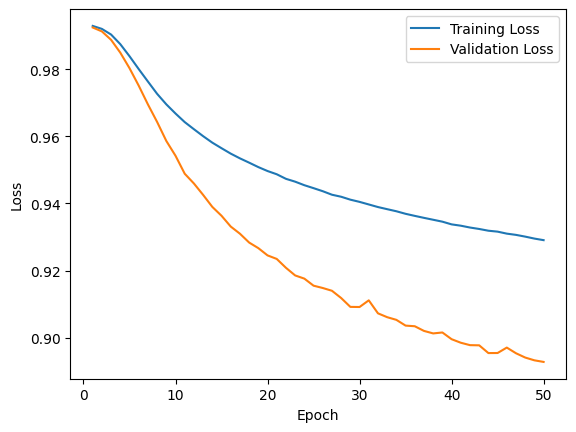

In [ ]:
HIDDEN_DIMS = [256, 512, 1024]
label_metadata = obtain_label_metadata(y_train_transformed, output_dim)
curr_model = WeightedMultiLabelNN(hidden_dims=HIDDEN_DIMS)
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=128)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))
trained_model_nn = train_model(curr_model, data_loader, data_loader_val, torch.tensor(label_metadata["pos_weights"][:output_dim]))



In [ ]:
def predict(model, dataloader, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            logits = model(X)
            out = torch.sigmoid(logits)
            preds.append(out.cpu())
            labels.append(y.cpu())

    preds = torch.cat(preds)
    labels = torch.cat(labels)
    return preds, labels


y_preds, y_labels = predict(trained_model_nn, data_loader_val, 'cuda')

pred_entry_ids_df = pd.DataFrame({"EntryID": X_val_entry_ids, "prediction": [row.tolist() for row in y_preds]})
label_names = mlb.classes_[:output_dim]
num_labels = len(label_names)
pred_matrix = np.vstack(pred_entry_ids_df["prediction"].values)

pred_df = pd.DataFrame(pred_matrix, columns=label_names)

prediction_df = pd.concat([pred_entry_ids_df[["EntryID"]], pred_df], axis=1)
go_cols = [c for c in prediction_df.columns if c != "EntryID"]
to_score_df = prediction_df.melt(id_vars="EntryID", value_vars=go_cols, var_name="term", value_name="score")

to_score_df = to_score_df.sort_values(["EntryID", "term"]).reset_index(drop=True)
to_score_df["score"] = to_score_df["score"].round(3)
to_score_df = to_score_df[to_score_df["score"] != 0]
to_score_df.to_csv(f"to_score_DNN.tsv", header=False, index=False, sep="\t")


ground_truth_score_df = protein_function_df[protein_function_df["EntryID"].isin(X_val_entry_ids)][["EntryID", "term"]]
ground_truth_score_df.to_csv(f"ground_truth_score_DNN.tsv", header=False, index=False, sep="\t")



In [ ]:
def obo_to_pyg(obo_path):
    G = obonet.read_obo(obo_path)
    nodes_F = [n for n in G.nodes if G.nodes[n]["namespace"] == "molecular_function"]
    nodes_C = [n for n in G.nodes if G.nodes[n]["namespace"] == "cellular_component"]
    nodes_P = [n for n in G.nodes if G.nodes[n]["namespace"] == "biological_process"]

    G_dict = {
        "F": G.subgraph(nodes_F),
        "C": G.subgraph(nodes_C),
        "P": G.subgraph(nodes_P)
    }
    G_data_dict = {}
    for k, curr_G in G_dict.items():
        go_list = sorted(curr_G.nodes())
        go_list.append("VIRTUAL")
        print(len(go_list))
        idx = {g:i for i,g in enumerate(go_list)}
        x = torch.arange(len(go_list), dtype=torch.long)
        e = []
        for edge in curr_G.edges:
            if edge[0] in idx and edge[1] in idx:
                e.append([idx[edge[0]], idx[edge[1]]])
                e.append([idx[edge[1]], idx[edge[0]]])

        virtual_idx = idx["VIRTUAL"]
        for node_idx in range(len(go_list) - 1):
            e.append([virtual_idx, node_idx])
            e.append([node_idx, virtual_idx])

        edge_index = torch.tensor(e, dtype=torch.long).t().contiguous()
        G_data_dict[k] = Data(x=x, edge_index=edge_index, go_ids=go_list)
    return G_data_dict

In [ ]:
class GODataset(GDataset):
    def __init__(self, graph, transform=None, pre_transform=None):
        super().__init__(None, transform, pre_transform)
        self.graph = graph
        self.num_nodes = self.graph.num_nodes

    def len(self):
        return self.num_nodes

    def get(self, idx):
        return Data(
            x=self.graph.x[idx].unsqueeze(0),
            edge_index=self.graph.edge_index,
            node_idx=torch.tensor([idx]),
            go_id=self.graph.go_ids[idx]
        )

In [ ]:
G_data_dict = obo_to_pyg(obo_path)

10132
4042
25951


In [ ]:
G_data_dict

{'F': Data(x=[10132], edge_index=[2, 45400], go_ids=[10132]),
 'C': Data(x=[4042], edge_index=[2, 20958], go_ids=[4042]),
 'P': Data(x=[25951], edge_index=[2, 168344], go_ids=[25951])}

In [ ]:
# Graph Sage from colab 3
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
from torch_geometric.utils import add_self_loops

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, n_terms, emb=False):
        # input_dim // 8
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args["model_type"])
        self.embeddings = nn.Embedding(n_terms, input_dim)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args["num_layers"] >= 1), 'Number of layers is not >=1'
        for l in range(args["num_layers"]-1):
            self.convs.append(conv_model(args["heads"] * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args["heads"] * hidden_dim, hidden_dim), nn.Dropout(args["dropout"]),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args["dropout"]
        self.num_layers = args["num_layers"]

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x_emb = self.embeddings(x)
        for i in range(self.num_layers):
            x_emb = self.convs[i](x_emb, edge_index)
            x_emb = F.relu(x_emb)
            x_emb = F.dropout(x_emb, p=self.dropout,training=self.training)

        x_emb = self.post_mp(x_emb)


        return x_emb

    def loss(self, pred, label):
        return F.nll_loss(pred, label)


class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        self.lin_l = nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = nn.Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        out = None
        num_nodes = x.size()[0]
        edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
        out = self.propagate(x=x, edge_index=edge_index)

        out = self.lin_l(x) + self.lin_r(out)
        if self.normalize: out = torch.nn.functional.normalize(out)

        return out

    def message(self, x_j):
        out = None
        out = x_j

        return out

    def aggregate(self, inputs, index, dim_size = None):
        out = None
        # The axis along which to index number of nodes.
        node_dim = self.node_dim
        out = torch_scatter.scatter(inputs, index, dim=0, reduce='mean')
        return out

class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        self.lin_l, self.lin_r = nn.Linear(in_channels, out_channels * self.heads), nn.Linear(in_channels, out_channels * self.heads)
        self.att_l, self.att_r = nn.Parameter(torch.empty(self.heads, out_channels)), nn.Parameter(torch.empty(self.heads, out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):

        H, C = self.heads, self.out_channels
        # print(f"{H} {C}")
        # print(x.shape)
        W_l_transformed_x, W_r_transformed_x = self.lin_l(x), self.lin_r(x)
        # print(f"W_l_tr_x: {W_l_transformed_x.shape}, W_r_tr_x:{W_r_transformed_x.shape}")
        N = x.size(0)
        x_l = W_l_transformed_x.view(N, H, C)
        x_r = W_r_transformed_x.view(N, H, C)
        # print(f"x_l {x_l.shape} x_r {x_r.shape} {self.att_l.shape} {self.att_r.shape}")
        alpha_central = (x_l * self.att_l.unsqueeze(0)).sum(dim=-1)
        alpha_neighbors = (x_r * self.att_r.unsqueeze(0)).sum(dim=-1)
        num_nodes = x.size()[0]
        edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_central, alpha_neighbors), size=size)
        out = out.view(N, H * C)
        # print(f"forward out.shape {out.shape}")

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        alpha = alpha_i + alpha_j
        alpha = F.leaky_relu(alpha, negative_slope=.2)
        alpha = softmax(alpha,index,num_nodes=size_i, ptr=ptr, )
        alpha = F.dropout(alpha, training=self.training, p=self.dropout)
        out = x_j * alpha.unsqueeze(-1)

        return out


    def aggregate(self, inputs, index, dim_size = None):
        out = torch_scatter.scatter(inputs, index, dim=0)
        # print(f"out aggregate: {out.shape}")
        return out


In [ ]:
import math
args_dict = {
    "heads": 1,
    "dropout": 0,
    "num_layers": 3,
    "model_type": "GraphSage"
}
class TwoTowerGNNAndNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, logits_dim, output_dim, graph_edge_dim, args_dict):
        super().__init__()
        self.NN = WeightedMultiLabelNN(input_dim=input_dim, output_dim=logits_dim)
        self.GNN = GNNStack(input_dim, hidden_dim, logits_dim, args_dict, graph_edge_dim)
        self.graph_edge_dim = graph_edge_dim
        self.W_map_graph = nn.Linear(graph_edge_dim, hidden_dim)
        self.final = nn.Linear(logits_dim, output_dim)
        self._init_weights

    def _init_weights(self):
        for module in self.NN.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

        for gnn in [self.GNN_C, self.GNN_F, self.GNN_P]:
            for module in gnn.modules():
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        nn.init.zeros_(module.bias)

        nn.init.xavier_uniform_(self.final.weight)
        nn.init.zeros_(self.final.bias)


    def forward(self, x_protein_embeddings, x_nodes, size=None):
        x_p = self.NN(x_protein_embeddings)
        x_n = self.GNN(x_nodes)
        x_n = self.W_map_graph(x_n.T)
        x_n = x_n.mean(dim=1)
        x = x_p + x_n
        logits = self.final(x)
        return logits


class TwoTowerGNNAndNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, logits_dim, output_dim, graph_edge_dim_C, graph_edge_dim_F, graph_edge_dim_P, args_dict, hidden_dims=[256, 512, 1024, 2048]):
        super().__init__()

        self.NN = WeightedMultiLabelNN(input_dim=input_dim, output_dim=logits_dim, hidden_dims=hidden_dims)
        self.GNN_C = GNNStack(input_dim, hidden_dim, logits_dim, args_dict, graph_edge_dim_C)
        self.GNN_F = GNNStack(input_dim, hidden_dim, logits_dim, args_dict, graph_edge_dim_F)
        self.GNN_P = GNNStack(input_dim, hidden_dim, logits_dim, args_dict, graph_edge_dim_P)
        self.final = nn.Linear(logits_dim*4, output_dim)

    def forward(self, x_protein_embeddings, x_nodes_C, x_nodes_F, x_nodes_P, size=None):
        x_p = self.NN(x_protein_embeddings)
        x_n_C = self.GNN_C(x_nodes_C)
        x_n_F = self.GNN_F(x_nodes_F)
        x_n_P = self.GNN_P(x_nodes_P)
        attention_scores_C = torch.matmul(x_p, x_n_C.T)
        attention_scores_P = torch.matmul(x_p, x_n_P.T)
        attention_scores_F = torch.matmul(x_p, x_n_F.T)
        attention_weights_C = F.softmax(attention_scores_C / math.sqrt(x_p.size(-1)), dim=-1)
        attention_weights_F = F.softmax(attention_scores_F / math.sqrt(x_p.size(-1)), dim=-1)
        attention_weights_P = F.softmax(attention_scores_P / math.sqrt(x_p.size(-1)), dim=-1)
        # x_n_weighted = torch.matmul(attention_weights, x_n)
        x_n_weighted_C = torch.matmul(attention_weights_C, x_n_C)
        x_n_weighted_F = torch.matmul(attention_weights_F, x_n_F)
        x_n_weighted_P = torch.matmul(attention_weights_P, x_n_P)
        x_n_weighted = x_n_weighted_C + x_n_weighted_F + x_n_weighted_P
        x_add = x_p + x_n_weighted
        # x_mult = x_p * x_n_weighted

        x_cat = torch.cat([x_p, x_n_weighted_C, x_n_weighted_F, x_n_weighted_P], dim=-1)
        logits = self.final(x_cat)
        return logits



In [ ]:
def evaluate_f1_multi_tower(model, val_loader, device,  graph_data_C, graph_data_F, graph_data_P, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.to(device)

            logits = model(features,  graph_data_C, graph_data_F, graph_data_P)
            probs = torch.sigmoid(logits)

            preds = (probs > threshold).float()

            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    num_labels = all_targets.shape[1]
    f1_scores = []

    for i in range(num_labels):
        try:
            f1 = f1_score(all_targets[:, i], all_preds[:, i], zero_division=0   )
        except ValueError:
            f1 = 0.0
        f1_scores.append(f1)

    f1_scores = np.array(f1_scores)
    best_idx = np.argsort(f1_scores)[-3:]
    worst_idx = np.argsort(f1_scores)[:3]

    return f1_scores, best_idx, worst_idx


In [ ]:
import warnings
warnings.filterwarnings("ignore")

def train_model_two_tower(model, train_loader, val_loader, graph_data_C, graph_data_F, graph_data_P, pos_weights, num_epochs=50):
    train_loss_list = []
    val_loss_list = []
    train_f1_score = []
    val_f1_score = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    pos_weights = pos_weights.to(device)
    graph_data_C = graph_data_C.to(device)
    graph_data_F = graph_data_F.to(device)
    graph_data_P = graph_data_P.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    f1_soft_weighted = WeightedMacroSoftF1Loss(pos_weights)
    for epoch in range(num_epochs):

        model.train()
        total_loss = 0.0

        for features, targets in train_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features, graph_data_C, graph_data_F, graph_data_P)


            loss = f1_soft_weighted(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        total_val_loss = 0.0
        avg_val_loss = 0.0
        if val_loader is not None:
          with torch.no_grad():
              for val_features, val_targets in val_loader:
                  val_features = val_features.to(device)
                  val_targets = val_targets.to(device)
                  val_logits = model(val_features, graph_data_C, graph_data_F, graph_data_P)
                  val_loss = f1_soft_weighted(val_logits, val_targets)
                  total_val_loss += val_loss.item()
          avg_val_loss = total_val_loss / len(val_loader)

        avg_loss = total_loss / len(train_loader)


        train_loss_list.append(avg_loss)


        # Validate using the validation dataloader

        print(f"curr epoch {epoch+1}/{num_epochs}] loss: {avg_loss} val_loss {avg_val_loss}")
        if val_loader is not None:
          val_loss_list.append(avg_val_loss)
          f1_scores, best_idx, worst_idx = evaluate_f1_multi_tower(model, val_loader, device,  graph_data_C, graph_data_F, graph_data_P)
          print("Validation op 3 labels (best F1):")
          for idx in reversed(best_idx):
              print(f"Label {idx}: F1 = {f1_scores[idx]}")

          print("Validation Bottom 3 labels (worst F1):")
          for idx in worst_idx:
              print(f"Label {idx}: F1 = {f1_scores[idx]}")

          print(f"Validation average f1 score: {np.mean(f1_scores)}")

    plt.plot(
        range(1, num_epochs + 1),
        train_loss_list,
        label="Training Loss",
    )
    if val_loader is not None:
      plt.plot(
          range(1, num_epochs + 1),
          val_loss_list,
          label="Validation Loss",
      )

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(f'two_tower_loss_{args_dict["model_type"]}.png')
    plt.show()
    return model

600
0


TRAINING: P model 


curr epoch 1/50] loss: 0.9799670999196459 val_loss 0.9424311032369275
Validation op 3 labels (best F1):
Label 52: F1 = 0.8
Label 3: F1 = 0.6389307228915663
Label 33: F1 = 0.5625
Validation Bottom 3 labels (worst F1):
Label 45: F1 = 0.0
Label 118: F1 = 0.0
Label 91: F1 = 0.0
Validation average f1 score: 0.10119742634212624
curr epoch 2/50] loss: 0.9575031213081888 val_loss 0.9246479956634244
Validation op 3 labels (best F1):
Label 52: F1 = 0.7272727272727273
Label 3: F1 = 0.6564685314685315
Label 193: F1 = 0.5365853658536586
Validation Bottom 3 labels (worst F1):
Label 13: F1 = 0.0
Label 15: F1 = 0.0
Label 48: F1 = 0.0
Validation average f1 score: 0.11461120540076805
curr epoch 3/50] loss: 0.9487401822425138 val_loss 0.9139296788324487
Validation op 3 labels (best F1):
Label 52: F1 = 0.7272727272727273
Label 3: F1 = 0.6583957219251337
Label 196: F1 = 0.5631067961165048
Validation Bottom 3 labels (worst F1):
Label 13: F1 = 0.0
Label 15: F1 = 0.0
Label 48: F1 

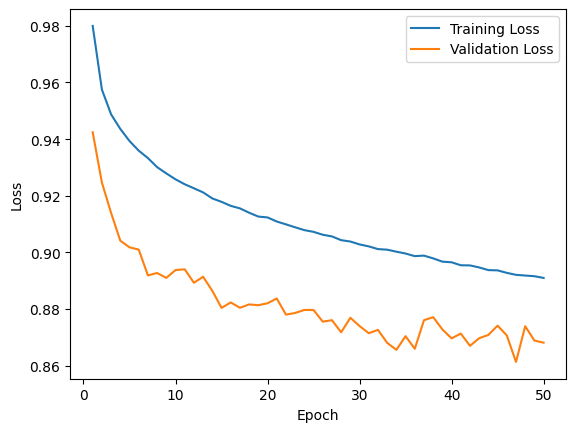

In [ ]:
# G_data_dict = obo_to_pyg(obo_path) # Get dictionaries

label_metadata = obtain_label_metadata(y_train_transformed, output_dim)
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=128)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))
print(f"\n\nTRAINING: {k} model \n\n")
curr_model = TwoTowerGNNAndNN(PCA_TARGET_DIM, 32, 64, output_dim,  G_data_dict['C'].x.size()[0], G_data_dict['F'].x.size()[0], G_data_dict['P'].x.size()[0], args_dict)
trained_model_nn = train_model_two_tower(curr_model, data_loader, data_loader_val, G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], torch.tensor(label_metadata["pos_weights"][:output_dim]))

In [ ]:
# 0.189 0.69, 0.65, 0.55 with bce

In [ ]:
def predict_two_tower(model, dataloader, G_data_C, G_data_F, G_data_P, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            logits = model(X, G_data_C, G_data_F, G_data_P)
            out = torch.sigmoid(logits)
            preds.append(out.cpu())
            labels.append(y.cpu())

    preds = torch.cat(preds)
    labels = torch.cat(labels)
    return preds, labels


y_preds, y_labels = predict_two_tower(trained_model_nn, data_loader_val,  G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], 'cuda')

pred_entry_ids_df = pd.DataFrame({"EntryID": X_val_entry_ids, "prediction": [row.tolist() for row in y_preds]})
label_names = mlb.classes_[:output_dim]
num_labels = len(label_names)
pred_matrix = np.vstack(pred_entry_ids_df["prediction"].values)

pred_df = pd.DataFrame(pred_matrix, columns=label_names)

prediction_df = pd.concat([pred_entry_ids_df[["EntryID"]], pred_df], axis=1)
go_cols = [c for c in prediction_df.columns if c != "EntryID"]
to_score_df = prediction_df.melt(id_vars="EntryID", value_vars=go_cols, var_name="term", value_name="score")

to_score_df = to_score_df.sort_values(["EntryID", "term"]).reset_index(drop=True)
to_score_df["score"] = to_score_df["score"].round(3)
to_score_df = to_score_df[to_score_df["score"] != 0]
to_score_df.to_csv(f"to_score2.tsv", header=False, index=False, sep="\t")


ground_truth_score_df = protein_function_df[protein_function_df["EntryID"].isin(X_val_entry_ids)][["EntryID", "term"]]
ground_truth_score_df.to_csv(f"ground_truth_score2.tsv", header=False, index=False, sep="\t")



In [ ]:
ground_truth_score_df_merged.to_csv("ground_truth_score6.tsv", header=False, index=False, sep="\t")
score_df_merged.to_csv("to_score6.tsv", header=False, index=False, sep="\t")

600
0
curr epoch 1/50] loss: 0.9788359029315855 val_loss 0.9452440887560158
Validation op 3 labels (best F1):
Label 52: F1 = 0.6666666666666666
Label 3: F1 = 0.6362957430918595
Label 196: F1 = 0.5567010309278351
Validation Bottom 3 labels (worst F1):
Label 15: F1 = 0.0
Label 20: F1 = 0.0
Label 41: F1 = 0.0
Validation average f1 score: 0.09796005592085107
curr epoch 2/50] loss: 0.9580527264917257 val_loss 0.9255395742755003
Validation op 3 labels (best F1):
Label 52: F1 = 0.8
Label 3: F1 = 0.6362957430918595
Label 196: F1 = 0.5346534653465347
Validation Bottom 3 labels (worst F1):
Label 15: F1 = 0.0
Label 20: F1 = 0.0
Label 48: F1 = 0.0
Validation average f1 score: 0.11293654049687053
curr epoch 3/50] loss: 0.95141685904472 val_loss 0.9117536376449359
Validation op 3 labels (best F1):
Label 52: F1 = 0.8
Label 3: F1 = 0.6362957430918595
Label 183: F1 = 0.6153846153846154
Validation Bottom 3 labels (worst F1):
Label 15: F1 = 0.0
Label 20: F1 = 0.0
Label 48: F1 = 0.0
Validation average f1 

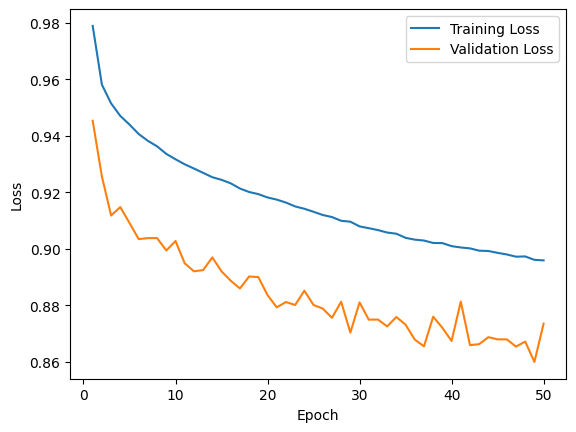

In [ ]:
args_dict = {
    "heads": 2,
    "dropout": 0,
    "num_layers": 3,
    "model_type": "GAT"
}


label_metadata = obtain_label_metadata(y_train_transformed, output_dim)
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=128)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))

curr_model = TwoTowerGNNAndNN(PCA_TARGET_DIM, 32, 64, output_dim, G_data_dict['C'].x.size()[0], G_data_dict['F'].x.size()[0], G_data_dict['P'].x.size()[0], args_dict)
trained_model_nn_gat = train_model_two_tower(curr_model, data_loader, data_loader_val, G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], torch.tensor(label_metadata["pos_weights"][:output_dim]))

In [ ]:

y_preds, y_labels = predict_two_tower(trained_model_nn_gat, data_loader_val,  G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], 'cuda')

pred_entry_ids_df = pd.DataFrame({"EntryID": X_val_entry_ids, "prediction": [row.tolist() for row in y_preds]})
label_names = mlb.classes_[:output_dim]
num_labels = len(label_names)
pred_matrix = np.vstack(pred_entry_ids_df["prediction"].values)

pred_df = pd.DataFrame(pred_matrix, columns=label_names)

prediction_df = pd.concat([pred_entry_ids_df[["EntryID"]], pred_df], axis=1)
go_cols = [c for c in prediction_df.columns if c != "EntryID"]
to_score_df = prediction_df.melt(id_vars="EntryID", value_vars=go_cols, var_name="term", value_name="score")

to_score_df = to_score_df.sort_values(["EntryID", "term"]).reset_index(drop=True)
to_score_df["score"] = to_score_df["score"].round(3)
to_score_df = to_score_df[to_score_df["score"] != 0]
to_score_df.to_csv(f"to_score_GAT.tsv", header=False, index=False, sep="\t")


ground_truth_score_df = protein_function_df[protein_function_df["EntryID"].isin(X_val_entry_ids)][["EntryID", "term"]]
ground_truth_score_df.to_csv(f"ground_truth_score_GAT.tsv", header=False, index=False, sep="\t")



In [ ]:
def predict_two_tower(model, dataloader, graph_data, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            logits = model(X, graph_data)
            out = torch.sigmoid(logits)
            preds.append(out.cpu())
            labels.append(y.cpu())

    preds = torch.cat(preds)
    labels = torch.cat(labels)
    return preds, labels

for k, subontology_metadata_dict in protein_function_metadata_dict.items():
      y_preds, y_labels = predict_two_tower(subontology_metadata_dict["trained_model_two_tower"], subontology_metadata_dict["data_loader_val"],  subontology_metadata_dict["graph_data_loader"], 'cuda')
      subontology_metadata_dict["y_preds_two_tower"] = y_preds
      subontology_metadata_dict["y_labels_two_tower"] = y_labels

for k, subontology_metadata_dict in protein_function_metadata_dict.items():
      pred_entry_ids_df = pd.DataFrame({"EntryID": subontology_metadata_dict["X_val_entry_ids"], "prediction": [row.tolist() for row in subontology_metadata_dict["y_preds_two_tower"]]})
      label_names = subontology_metadata_dict["mlb"].classes_[:output_dim]
      num_labels = len(label_names)

      pred_matrix = np.vstack(pred_entry_ids_df["prediction"].values)

      pred_df = pd.DataFrame(pred_matrix, columns=label_names)

      prediction_df = pd.concat([pred_entry_ids_df[["EntryID"]], pred_df], axis=1)
      go_cols = [c for c in prediction_df.columns if c != "EntryID"]
      to_score_df = prediction_df.melt(id_vars="EntryID", value_vars=go_cols, var_name="term", value_name="score")

      to_score_df = to_score_df.sort_values(["EntryID", "term"]).reset_index(drop=True)
      to_score_df["score"] = to_score_df["score"].round(3)
      to_score_df = to_score_df[to_score_df["score"] != 0]
      subontology_metadata_dict["to_score_df"] = to_score_df
      to_score_df.to_csv(f"to_score_{k}.tsv", header=False, index=False, sep="\t")

for k, curr_protein_function_df in protein_function_subontology_dict.items():
    ground_truth_score_df = curr_protein_function_df[curr_protein_function_df["EntryID"].isin(protein_function_metadata_dict[k]["X_val_entry_ids"])][["EntryID", "term"]]
    print(f"{k}, {len(ground_truth_score_df)}")
    protein_function_metadata_dict[k]["ground_truth_score_df"] = ground_truth_score_df

for k, subontology_metadata_dict in protein_function_metadata_dict.items():
    subontology_metadata_dict["ground_truth_score_df"].to_csv(f"ground_truth_score_{k}.tsv", header=False, index=False, sep="\t")

ground_truth_score_df_merged = pd.concat([
    protein_function_metadata_dict["C"]["ground_truth_score_df"],
    protein_function_metadata_dict["F"]["ground_truth_score_df"],
    protein_function_metadata_dict["P"]["ground_truth_score_df"]
], ignore_index=True)

score_df_merged = pd.concat([
    protein_function_metadata_dict["C"]["to_score_df"],
    protein_function_metadata_dict["F"]["to_score_df"],
    protein_function_metadata_dict["P"]["to_score_df"]
], ignore_index=True)


C, 14701
F, 10640
P, 17865


In [ ]:
ground_truth_score_df_merged.to_csv("ground_truth_score5.tsv", header=False, index=False, sep="\t")
score_df_merged.to_csv("to_score5.tsv", header=False, index=False, sep="\t")

In [ ]:
import torch_geometric as torch_g
data_loader_cora = torch_g.data.DataLoader(dataset, batch_size=64, shuffle=False)
for batch in data_loader_cora:
    print(batch)
    break

DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], batch=[2708], ptr=[2])


In [ ]:
graph = obonet.read_obo(obo_path)
graph

### Combine GO embedding and PLM embedding into one dataset

In [ ]:
grouped_df, protein_function_unique_metadata = group_terms_and_aspects(protein_function_df, N_TERMS_TO_PREDICT, get_all=True)

In [ ]:
len(protein_function_unique_metadata)

26125

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer

INCLUDE_TEST = False
test_df = None
# Columns for Training and Columns for Testing
PREDICTORS = [f"emb_{i}" for i in range(PCA_TARGET_DIM)]
PREDICTORS.append("EntryID")

OUTPUTS = ['output_terms']
subontology_train_val_test_dic = {}
if INCLUDE_TEST:
  X_test = test_df[PREDICTORS].values
X_train, y_train = grouped_df[PREDICTORS].values, grouped_df[OUTPUTS].iloc[:, 0].tolist()


X_entry_ids = [data_row[-1] for data_row in X_train]
X_train = np.array([data_row[:-1] for data_row in X_train])
if INCLUDE_TEST:
    X_test = np.array([data_row[:-1] for data_row in X_test])
    X_test_entry_ids = [data_row[-1] for data_row in X_test]

term_to_index = {term: i for i, term in enumerate(protein_function_unique_metadata)}

mlb = MultiLabelBinarizer(classes=protein_function_unique_metadata)
y_train_transformed = mlb.fit_transform(y_train)
print(len(protein_function_unique_metadata))
print(len(X_y_train_transformed[0]))
imputer = SimpleImputer(strategy="constant", fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)

26125


In [ ]:
from sklearn.metrics import f1_score

def evaluate_f1(model, val_loader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            probs = torch.sigmoid(logits)

            preds = (probs > threshold).float()

            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    num_labels = all_targets.shape[1]
    f1_scores = []

    for i in range(num_labels):
        try:
            f1 = f1_score(all_targets[:, i], all_preds[:, i], zero_division=0   )
        except ValueError:
            f1 = 0.0
        f1_scores.append(f1)

    f1_scores = np.array(f1_scores)
    best_idx = np.argsort(f1_scores)[-3:]
    worst_idx = np.argsort(f1_scores)[:3]

    return f1_scores, best_idx, worst_idx


In [ ]:
len(protein_function_unique_metadata)

26125

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
N_TERMS_TO_PREDICT = len(protein_function_unique_metadata)
output_dim = N_TERMS_TO_PREDICT
INCLUDE_TEST = True
test_df = fasta_emb_df
# Columns for Training and Columns for Testing
PREDICTORS = [f"emb_{i}" for i in range(PCA_TARGET_DIM)]
PREDICTORS.append("EntryID")

OUTPUTS = ['output_terms']
subontology_train_val_test_dic = {}
if INCLUDE_TEST:
  X_test = test_df[PREDICTORS].values
X, y = grouped_df[PREDICTORS].values, grouped_df[OUTPUTS].iloc[:, 0].tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.02, random_state=42)


X_train_entry_ids = [data_row[-1] for data_row in X_train]
X_val_entry_ids = [data_row[-1] for data_row in X_val]
X_train = np.array([data_row[:-1] for data_row in X_train])
X_val = np.array([data_row[:-1] for data_row in X_val])
if INCLUDE_TEST:
    print(len(X_val[0]))
    print(len(X_test[0]))
    X_test = np.array([data_row[:-1] for data_row in X_test])
    X_test_entry_ids = [data_row[-1] for data_row in X_test]
# print(len(X_val_entry_ids))

# print(len(X_val))
# print(len(y_val))

protein_function_unique_metadata_dict
term_to_index = {term: i for i, term in enumerate(protein_function_unique_metadata)}

mlb = MultiLabelBinarizer(classes=protein_function_unique_metadata)
y_train_transformed = mlb.fit_transform(y_train)
y_val_transformed = mlb.transform(y_val)
print(y_val_transformed[0])
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="constant", fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

128
129
[0 0 0 ... 0 0 0]


In [ ]:
len(y_train_transformed[0]), output_dim


(26125, 26125)

In [ ]:
protein_embeddings_dataset_train = ProteinEmbeddingsDataset(X_train_imputed, y_train_transformed, total_labels=output_dim)
protein_embeddings_dataset_val = ProteinEmbeddingsDataset(X_val_imputed, y_val_transformed, total_labels=output_dim)
protein_embeddings_dataset_test = ProteinEmbeddingsDataset(X_test, None, total_labels=output_dim, is_test=True)


In [ ]:
for batch in protein_embeddings_dataset_test:
  print()

In [ ]:
output_dim = len(protein_function_unique_metadata)
label_metadata = obtain_label_metadata(y_train_transformed, output_dim)

26125
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


In [ ]:
label_metadata

{'pos_weights': [np.float64(75.78111587982832),
  np.float64(160.53498871331828),
  1.0,
  1.0,
  1.0,
  np.float64(94.92493297587131),
  np.float64(1.1682220336928857),
  1.0,
  np.float64(34.601990049751244),
  1.0,
  np.float64(928.3506493506494),
  1.0,
  np.float64(192.92953929539294),
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  np.float64(19.52193862919415),
  1.0,
  1.0,
  1.0,
  1.0,
  np.float64(349.7843137254902),
  1.0,
  np.float64(803.0449438202247),
  1.0,
  1.0,
  np.float64(276.3643410852713),
  1.0,
  1.0,
  np.float64(6.207896857373086),
  1.0,
  1.0,
  1.0,
  np.float64(4.612108854207513),
  np.float64(744.4166666666666),
  1.0,
  np.float64(446.25),
  1.0,
  np.float64(1083.2424242424242),
  np.float64(21.46076585059636),
  np.float64(6.747942832394976),
  1.0,
  np.float64(215.84848484848484),
  np.float64(127.01431127012522),
  np.float64(529.074074074074),
  np.float64(24.759539236861052),
  1.0,
  1.0,
  np.float64(13.465332524762482),
  np.float64(4.4915

In [ ]:
len(label_metadata["pos_weights"])

26125

num_labels 26125
curr epoch 1/50] loss: 0.9999269818977679 val_loss 0.9999056945444392
Validation op 3 labels (best F1):
Label 21527: F1 = 1.0
Label 2379: F1 = 0.9090909090909091
Label 1065: F1 = 0.6666666666666666
Validation Bottom 3 labels (worst F1):
Label 17335: F1 = 0.0
Label 17347: F1 = 0.0
Label 17346: F1 = 0.0
Validation average f1 score: 0.002181646038811278
num_labels 26125
curr epoch 2/50] loss: 0.9998059473904136 val_loss 0.9993120060412428
Validation op 3 labels (best F1):
Label 19950: F1 = 1.0
Label 10436: F1 = 1.0
Label 9206: F1 = 1.0
Validation Bottom 3 labels (worst F1):
Label 17344: F1 = 0.0
Label 17356: F1 = 0.0
Label 17355: F1 = 0.0
Validation average f1 score: 0.011680900972632328
num_labels 26125
curr epoch 3/50] loss: 0.9992753221451512 val_loss 0.9976119402452803
Validation op 3 labels (best F1):
Label 6690: F1 = 1.0
Label 7171: F1 = 1.0
Label 16067: F1 = 1.0
Validation Bottom 3 labels (worst F1):
Label 17350: F1 = 0.0
Label 17362: F1 = 0.0
Label 17361: F1 = 0.0

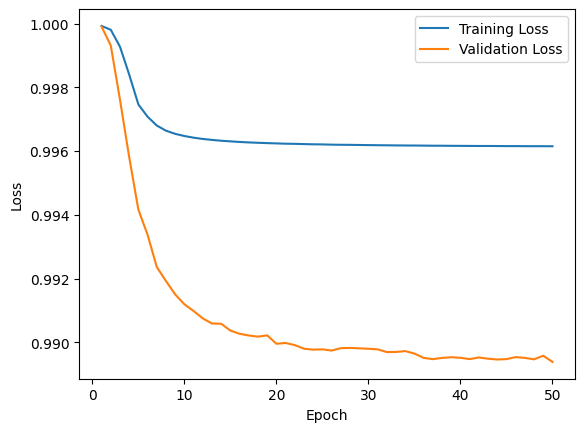

In [ ]:
curr_model = WeightedMultiLabelNN(hidden_dims=[256, 512, 1024, 2048], output_dim=len(protein_function_unique_metadata))
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=128)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))
trained_model_nn = train_model(curr_model, data_loader, data_loader_val, torch.tensor(label_metadata["pos_weights"]))

In [ ]:
PATH = "model_checkpoint_final.pth"
torch.save(trained_model_nn.state_dict(), PATH)

In [ ]:
PATH = "model_checkpoint_final.pth"
# state_dict = torch.load('model_checkpoint_final', map_location=device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
curr_model = WeightedMultiLabelNN(hidden_dims=[256, 512, 1024, 2048], output_dim=len(protein_function_unique_metadata))
curr_model.load_state_dict(torch.load('model_checkpoint_final.pth', map_location=device))

/tmp/ipython-input-3926569201.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  curr_model.load_state_dict(torch.load('model_checkpoint_final.pth', map_location=device))


<All keys matched successfully>

In [ ]:
device

device(type='cuda')

In [ ]:
trained_model_nn = curr_model.to(device)

In [ ]:
def predict_test(model, dataloader, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            X = batch
            X = X.to(device)

            logits = model(X)
            out = torch.sigmoid(logits)
            preds.append(out.cpu())

    preds = torch.cat(preds)
    return preds

data_loader_test = DataLoader(protein_embeddings_dataset_test, batch_size=128)
y_preds = predict_test(trained_model_nn, data_loader_test, 'cuda')

pred_entry_ids_df = pd.DataFrame({"EntryID": X_test_entry_ids, "prediction": [row.tolist() for row in y_preds]})
label_names = mlb.classes_
num_labels = len(label_names)
pred_matrix = np.vstack(pred_entry_ids_df["prediction"].values)

pred_df = pd.DataFrame(pred_matrix, columns=label_names)

prediction_df = pd.concat([pred_entry_ids_df[["EntryID"]], pred_df], axis=1)
go_cols = [c for c in prediction_df.columns if c != "EntryID"]
to_score_df = prediction_df.melt(id_vars="EntryID", value_vars=go_cols, var_name="term", value_name="score")

to_score_df = to_score_df.sort_values(["EntryID", "term"]).reset_index(drop=True)
to_score_df["score"] = to_score_df["score"].round(3)
to_score_df = to_score_df[to_score_df["score"] != 0]
to_score_df.to_csv(f"to_score_NN_test.tsv", header=False, index=False, sep="\t")


# ground_truth_score_df = protein_function_df[protein_function_df["EntryID"].isin(X_val_entry_ids)][["EntryID", "term"]]
# ground_truth_score_df.to_csv(f"ground_truth_score_DNN.tsv", header=False, index=False, sep="\t")



In [ ]:

label_metadata = obtain_label_metadata(y_train_transformed, output_dim)
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=256)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))
print(f"\n\nTRAINING: {k} model \n\n")
curr_model = TwoTowerGNNAndNN(PCA_TARGET_DIM, 64, 128, output_dim,  G_data_dict['C'].x.size()[0], G_data_dict['F'].x.size()[0], G_data_dict['P'].x.size()[0], args_dict, hidden_dims=[256, 512, 1024, 2048, 4096])
trained_model_nn_final = train_model_two_tower(curr_model, data_loader, data_loader_val, G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], torch.tensor(label_metadata["pos_weights"][:output_dim]))

26125
0


TRAINING: P model 


curr epoch 1/50] loss: 0.9991720147121895 val_loss 0.9820777363177472
Validation op 3 labels (best F1):
Label 11: F1 = 0.2202668180527959
Label 35: F1 = 0.2024983563445102
Label 1: F1 = 0.18181818181818182
Validation Bottom 3 labels (worst F1):
Label 5: F1 = 0.0
Label 4: F1 = 0.0
Label 15: F1 = 0.0
Validation average f1 score: 0.014569961613149414
curr epoch 2/50] loss: 0.9967267193342991 val_loss 0.9873010706800281
Validation op 3 labels (best F1):
Label 3: F1 = 0.47353154459753444
Label 84: F1 = 0.20408163265306123
Label 85: F1 = 0.16877637130801687
Validation Bottom 3 labels (worst F1):
Label 5: F1 = 0.0
Label 4: F1 = 0.0
Label 15: F1 = 0.0
Validation average f1 score: 0.013415891499364037
curr epoch 3/50] loss: 0.9953318236466983 val_loss 0.9863617612263329
Validation op 3 labels (best F1):
Label 3: F1 = 0.3612040133779264
Label 85: F1 = 0.2191780821917808
Label 136: F1 = 0.18181818181818182
Validation Bottom 3 labels (worst F1):
Label 5: F1 = 0.0
Lab

KeyboardInterrupt: 

In [ ]:
def predict_two_tower(model, dataloader, G_data_C, G_data_F, G_data_P, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            logits = model(X, G_data_C, G_data_F, G_data_P)
            out = torch.sigmoid(logits)
            preds.append(out.cpu())
            labels.append(y.cpu())

    preds = torch.cat(preds)
    labels = torch.cat(labels)
    return preds, labels


y_preds, y_labels = predict_two_tower(trained_model_nn, data_loader,  G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], 'cuda')

pred_entry_ids_df = pd.DataFrame({"EntryID": X_val_entry_ids, "prediction": [row.tolist() for row in y_preds]})
label_names = mlb.classes_[:output_dim]
num_labels = len(label_names)
pred_matrix = np.vstack(pred_entry_ids_df["prediction"].values)

pred_df = pd.DataFrame(pred_matrix, columns=label_names)

prediction_df = pd.concat([pred_entry_ids_df[["EntryID"]], pred_df], axis=1)
go_cols = [c for c in prediction_df.columns if c != "EntryID"]
to_score_df = prediction_df.melt(id_vars="EntryID", value_vars=go_cols, var_name="term", value_name="score")

to_score_df = to_score_df.sort_values(["EntryID", "term"]).reset_index(drop=True)
to_score_df["score"] = to_score_df["score"].round(3)
to_score_df = to_score_df[to_score_df["score"] != 0]
to_score_df.to_csv(f"to_score2.tsv", header=False, index=False, sep="\t")


ground_truth_score_df = protein_function_df[protein_function_df["EntryID"].isin(X_val_entry_ids)][["EntryID", "term"]]
ground_truth_score_df.to_csv(f"ground_truth_score2.tsv", header=False, index=False, sep="\t")

